# Si Data Tuh Notebook
### made by

## Import Library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import optuna
import joblib
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42

## Import Dataset

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Exploratory Data Analysis

In [ ]:
# Cek persentase null untuk train dataset
print("Train Dataset - Persentase Missing Values:")
train_null_percentage = (train_df.isnull().sum() / len(train_df)) * 100
print(train_null_percentage[train_null_percentage > 0].sort_values(ascending=False))

print("\n" + "="*50 + "\n")

# Cek persentase null untuk test dataset
print("Test Dataset - Persentase Missing Values:")
test_null_percentage = (test_df.isnull().sum() / len(test_df)) * 100
print(test_null_percentage[test_null_percentage > 0].sort_values(ascending=False))

Train Dataset - Persentase Missing Values:
Jenis_Tanaman             2.7375
Hasil_Panen_Ton_per_HA    2.5000
Akses_Irigasi             2.2625
Total_Curah_Hujan_mm      2.2375
dtype: float64


Test Dataset - Persentase Missing Values:
Series([], dtype: float64)


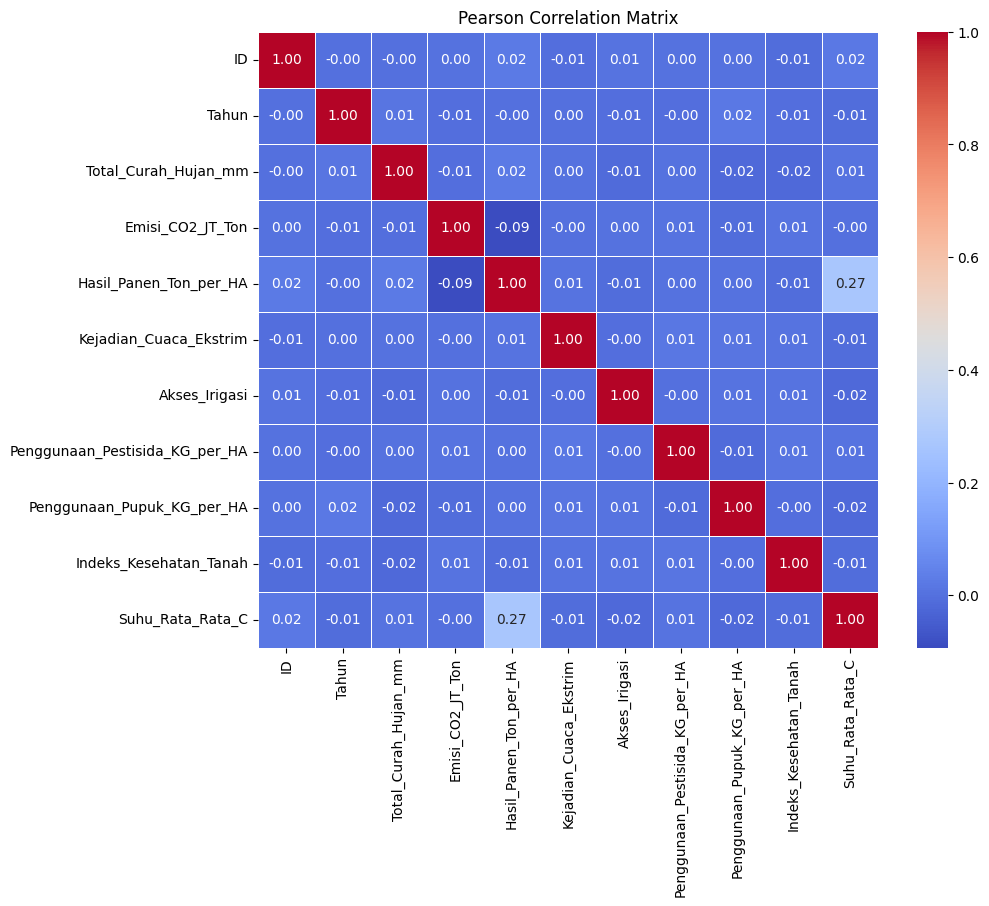

In [ ]:
correlation_matrix = train_df.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.show()

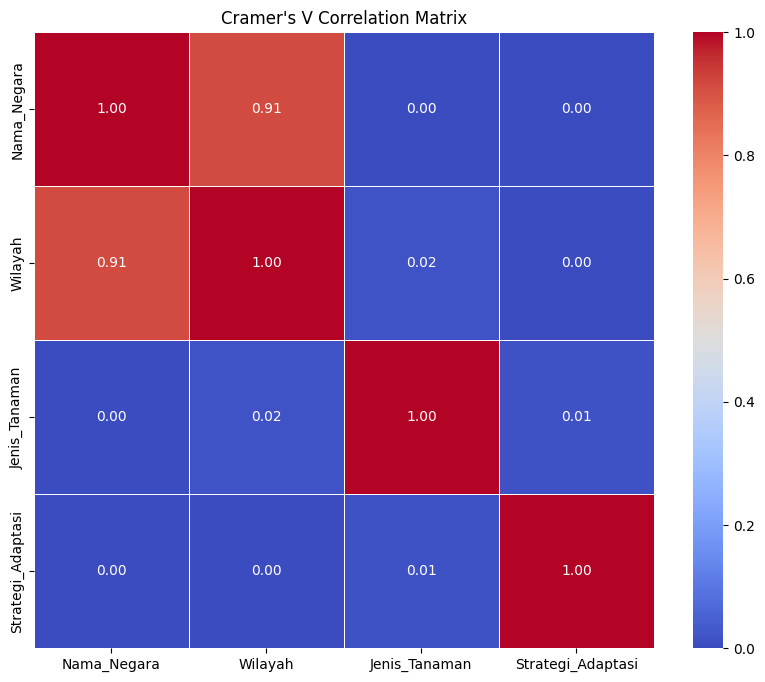

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_cols = train_df.select_dtypes(include='object').columns

cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(train_df[col1], train_df[col2])

cramer_matrix = cramer_matrix.apply(pd.to_numeric)
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Cramer's V Correlation Matrix")
plt.show()

Cramer's V with dropout_rate_percent:




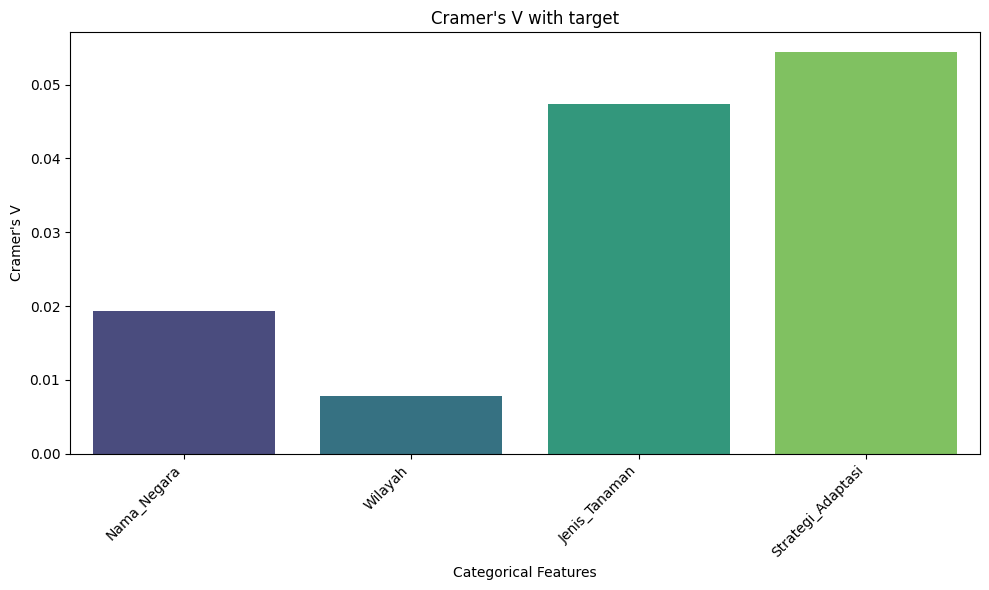

In [ ]:
# Calculate Cramer's V between categorical columns and the target variable
categorical_cols = train_df.select_dtypes(include='object').columns
target_col = 'Suhu_Rata_Rata_C'

cramer_v_with_target = {}
for col in categorical_cols:
    if col != target_col:
        cramer_v_with_target[col] = cramers_v(train_df[col], train_df[target_col])

print("Cramer's V with Suhu_Rata_Rata_C:")


print("\n" + "="*50 + "\n")

numerical_cols = train_df.select_dtypes(include=np.number).columns
pearson_corr_with_target = train_df[numerical_cols].corr(method='pearson')[target_col].drop(target_col)
plt.figure(figsize=(10, 6))
cramer_series = pd.Series(cramer_v_with_target)
sns.barplot(x=cramer_series.index, y=cramer_series.values, palette='viridis')
plt.title("Cramer's V with target")
plt.ylabel("Cramer's V")
plt.xlabel("Categorical Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

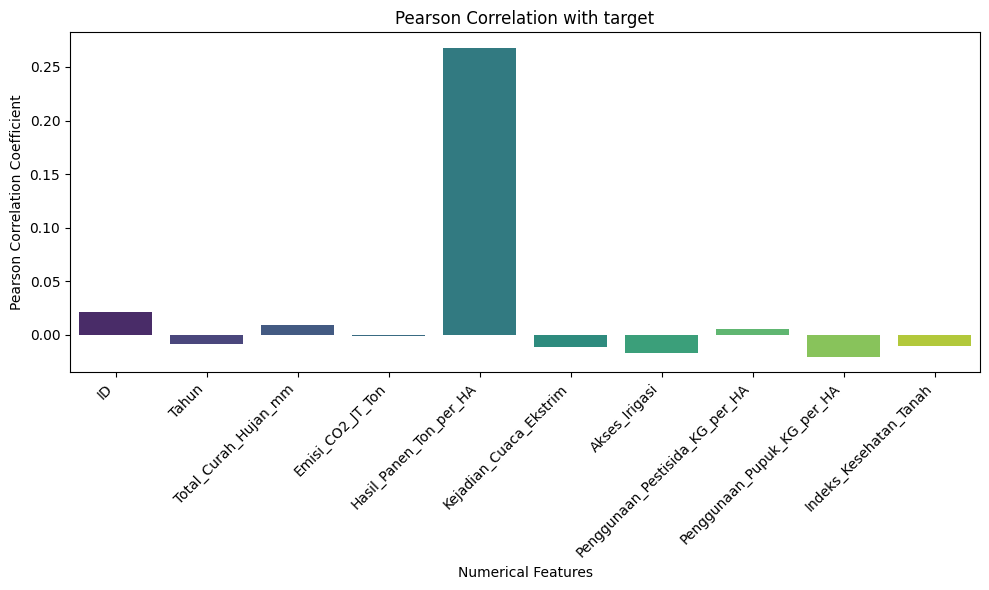

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pearson_corr_with_target.index, y=pearson_corr_with_target.values, palette='viridis')
plt.title("Pearson Correlation with target")
plt.ylabel("Pearson Correlation Coefficient")
plt.xlabel("Numerical Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

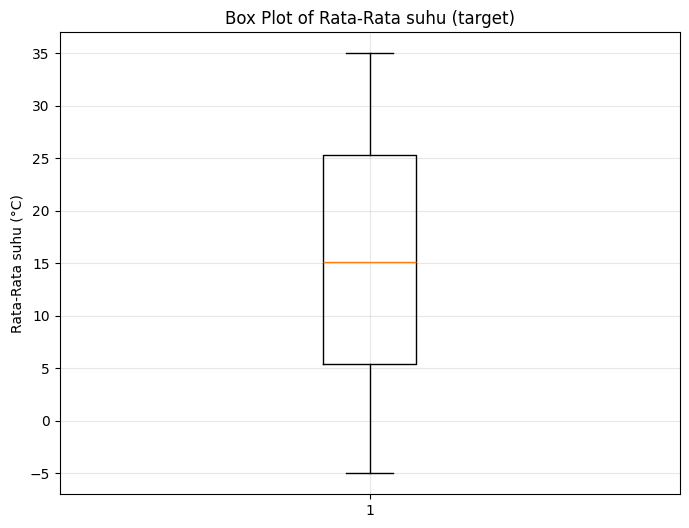

Summary Statistics for target:
Mean: 15.21
Median: 15.14
Std: 11.49
Min: -4.99
Max: 35.00
25th percentile (Q1): 5.38
75th percentile (Q3): 25.34
Count below 25th percentile: 2000
Count above 75th percentile: 1997


In [ ]:
target = train_df['Suhu_Rata_Rata_C']
plt.figure(figsize=(8, 6))
plt.boxplot(target, vert=True)
plt.ylabel('Rata-Rata suhu (°C)')
plt.title('Box Plot of Rata-Rata suhu (target)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Summary Statistics for target:")
print(f"Mean: {target.mean():.2f}")
print(f"Median: {target.median():.2f}")
print(f"Std: {target.std():.2f}")
print(f"Min: {target.min():.2f}")
print(f"Max: {target.max():.2f}")
# Calculate percentiles
q25 = target.quantile(0.25)
q75 = target.quantile(0.75)

count_below_q25 = (target < q25).sum()
count_above_q75 = (target > q75).sum()

print(f"25th percentile (Q1): {q25:.2f}")
print(f"75th percentile (Q3): {q75:.2f}")
print(f"Count below 25th percentile: {count_below_q25}")
print(f"Count above 75th percentile: {count_above_q75}")

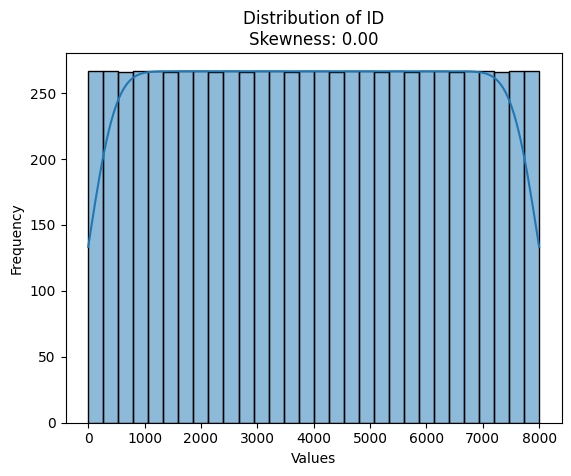

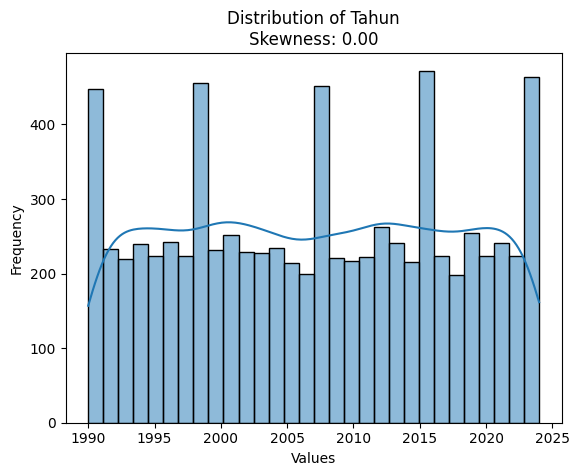

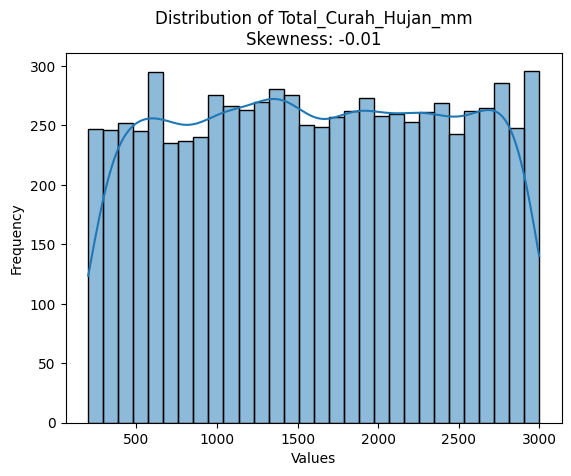

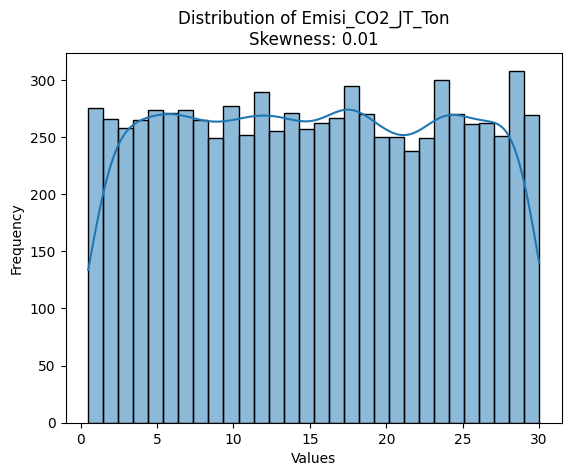

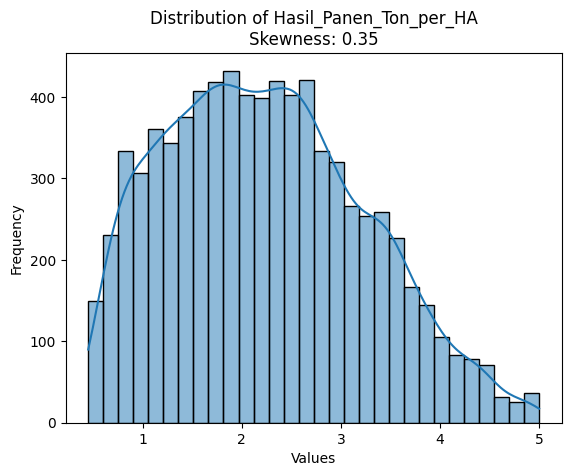

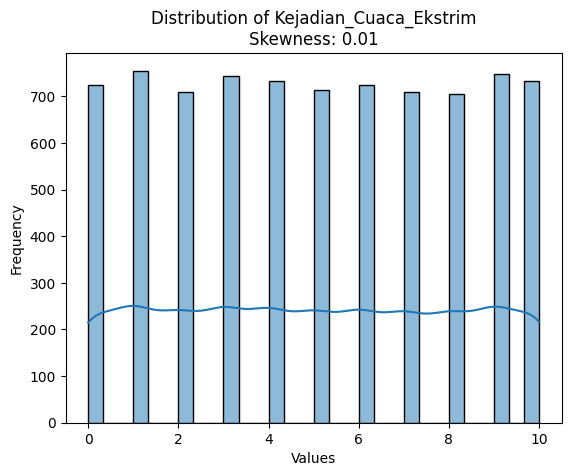

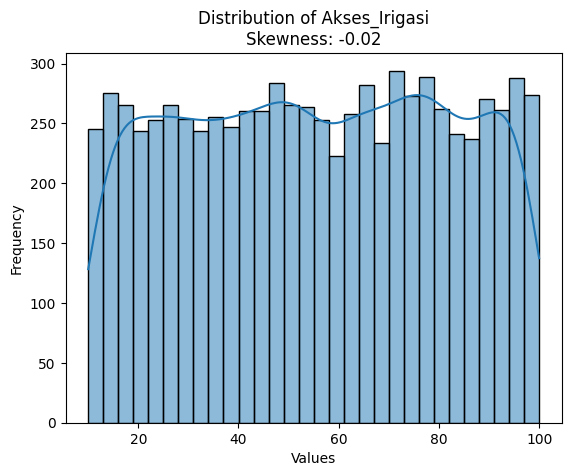

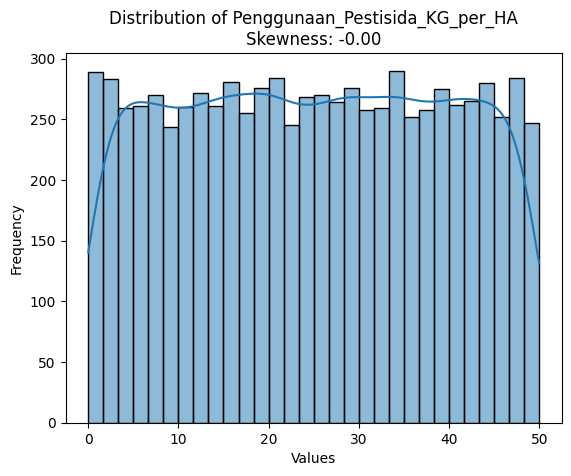

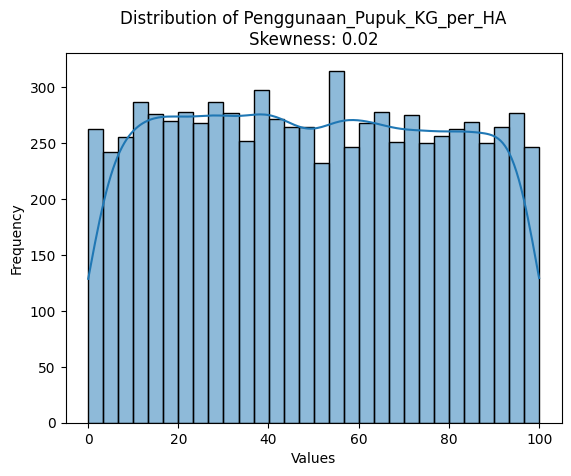

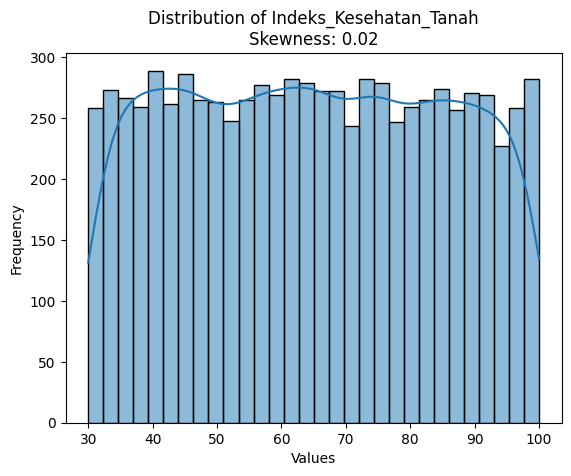

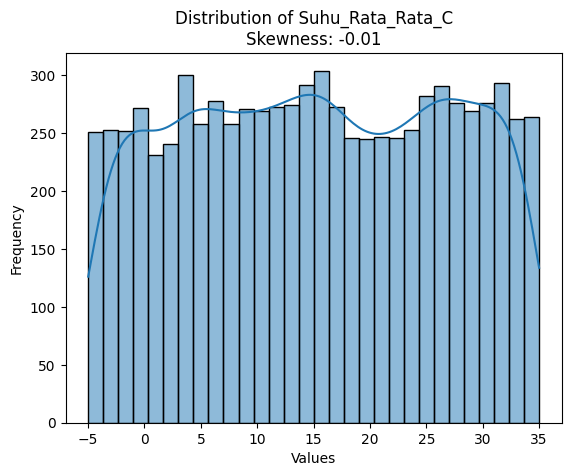

In [ ]:
numerical_cols = train_df.select_dtypes(include=np.number).columns
skewness = train_df[numerical_cols].skew().sort_values(ascending=False)

for col in numerical_cols:
  sns.histplot(train_df[col], kde=True, bins=30)
  plt.title(f'Distribution of {col}\nSkewness: {skewness[col]:.2f}') # Add skewness to title
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.show()

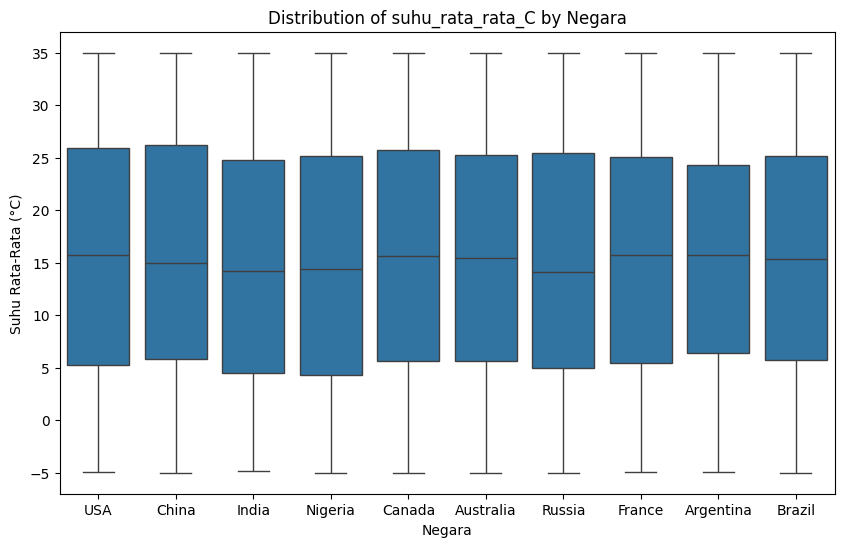

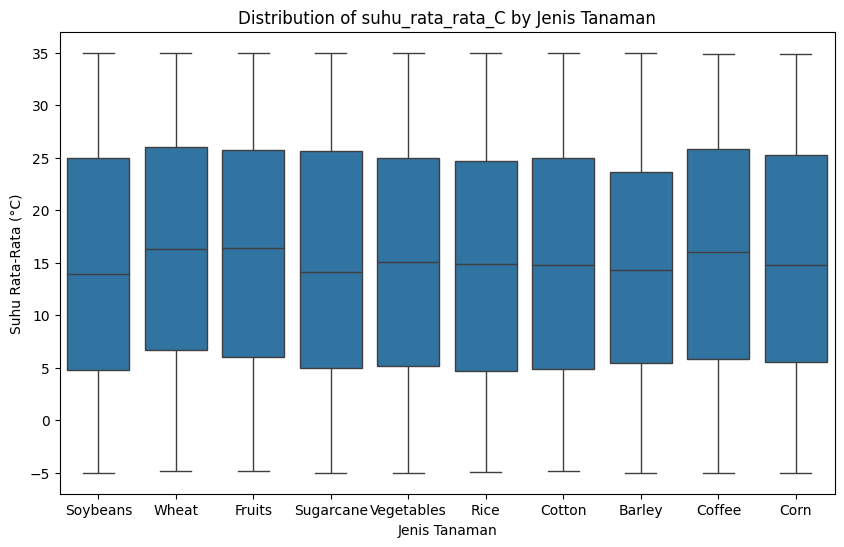

In [ ]:
# Box plot of Suhu_Rata_Rata_C by Negara
plt.figure(figsize=(10, 6))
sns.boxplot(x='Nama_Negara', y='Suhu_Rata_Rata_C', data=train_df)
plt.title('Distribution of suhu_rata_rata_C by Negara')
plt.xlabel('Negara')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.show()

# Box plot of suhu_rata_rata_C by Jenis Tanaman
plt.figure(figsize=(10, 6))
sns.boxplot(x='Jenis_Tanaman', y='Suhu_Rata_Rata_C', data=train_df)
plt.title('Distribution of suhu_rata_rata_C by Jenis Tanaman')
plt.xlabel('Jenis Tanaman')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.show()

EDA: Menganalisis Tren Suhu Global per Tahun...


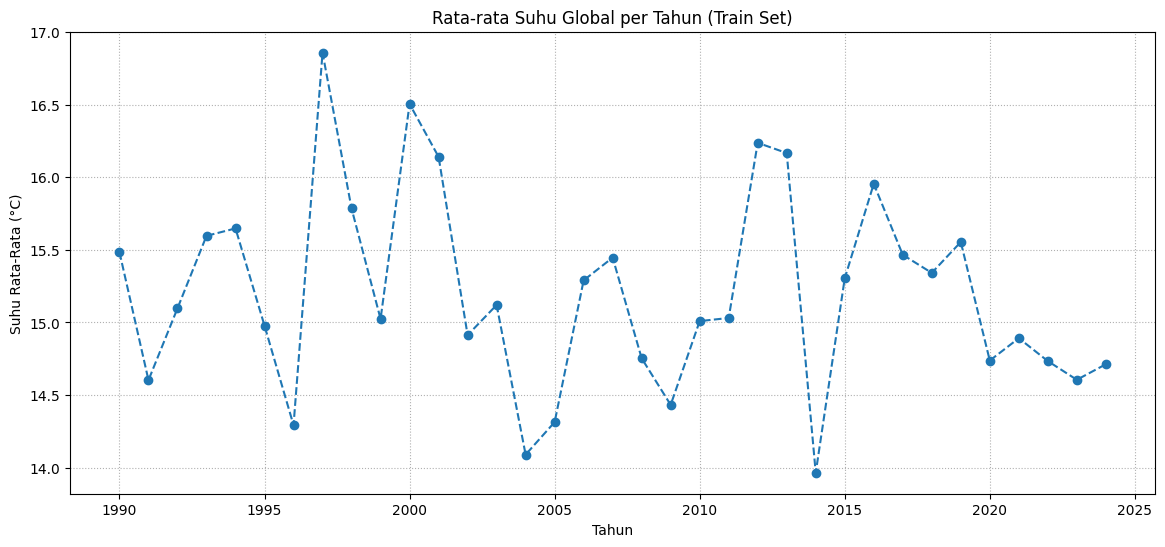


EDA: Analisis Tren Suhu per Negara (Top 5 Negara)...


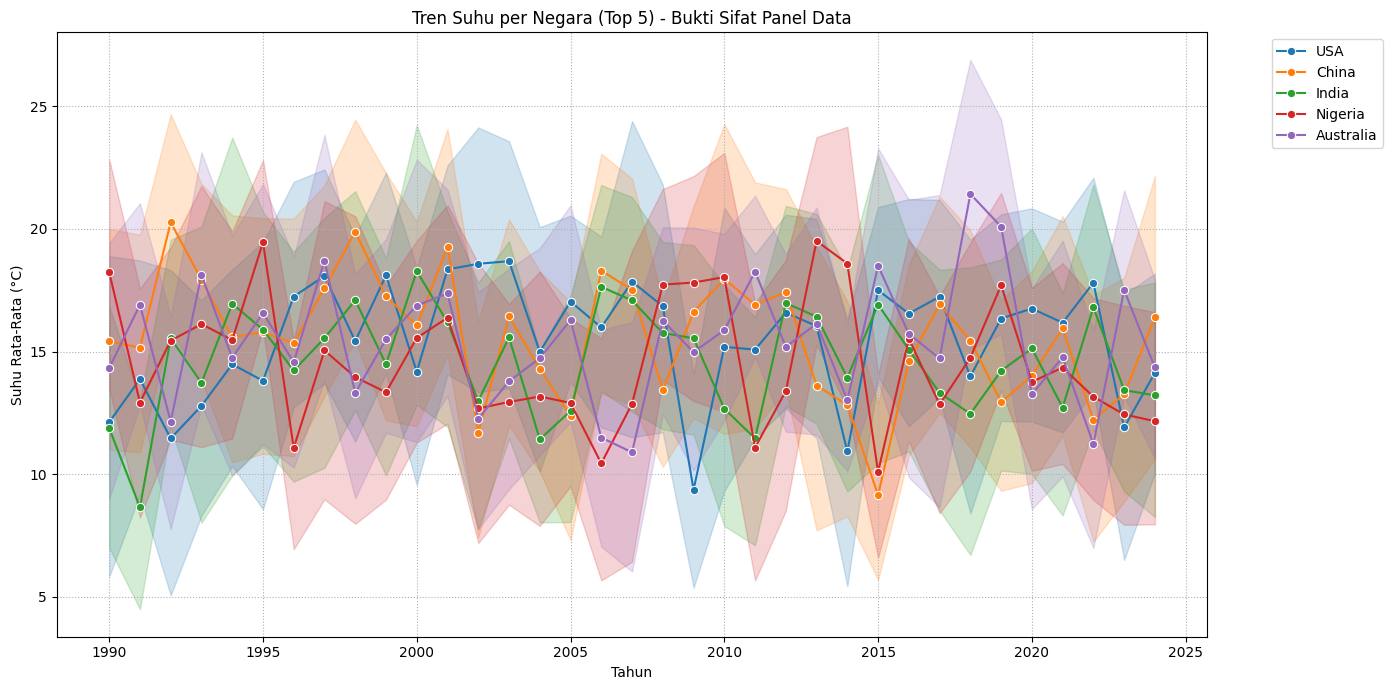

In [ ]:
# Analisis Tren Temporal (Global vs Per Negara)

print("EDA: Analisis Tren Suhu Global per Tahun...")
plt.figure(figsize=(14, 6))
mean_temp_per_year = train_df.groupby('Tahun')['Suhu_Rata_Rata_C'].mean()
mean_temp_per_year.plot(marker='o', linestyle='--')
plt.title('Rata-rata Suhu Global per Tahun (Train Set)')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.grid(True, linestyle=':')
plt.show()

print("\nEDA: Analisis Tren Suhu per Negara (Top 5 Negara)...")
top_5_countries = train_df['Nama_Negara'].value_counts().nlargest(5).index
df_top5 = train_df[train_df['Nama_Negara'].isin(top_5_countries)]

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_top5, x='Tahun', y='Suhu_Rata_Rata_C', hue='Nama_Negara', marker='o')
plt.title('Tren Suhu per Negara (Top 5) - Bukti Sifat Panel Data')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


EDA: Komparasi Statistik Detail 'North West' vs 'Others'...
Data dipisahkan: NW (201 baris), Others (7799 baris)

Perbandingan Distribusi Target (Suhu_Rata_Rata_C):
|       |     NW |   Others |
|:------|-------:|---------:|
| count | 201.00 |  7799.00 |
| mean  |  15.44 |    15.20 |
| std   |  11.50 |    11.49 |
| min   |  -4.79 |    -4.99 |
| 25%   |   4.81 |     5.38 |
| 50%   |  15.87 |    15.11 |
| 75%   |  25.73 |    25.31 |
| max   |  34.51 |    35.00 |

Perbandingan Statistik Fitur Kunci:
|                            |   ('NW', 'mean') |   ('NW', 'std') |   ('NW', 'median') |   ('NW', 'skew') |   ('Others', 'mean') |   ('Others', 'std') |   ('Others', 'median') |   ('Others', 'skew') |   ('Diff', 'Rel_Mean_Std') |
|:---------------------------|-----------------:|----------------:|-------------------:|-----------------:|---------------------:|--------------------:|-----------------------:|---------------------:|---------------------------:|
| Total_Curah_Hujan_mm       |       

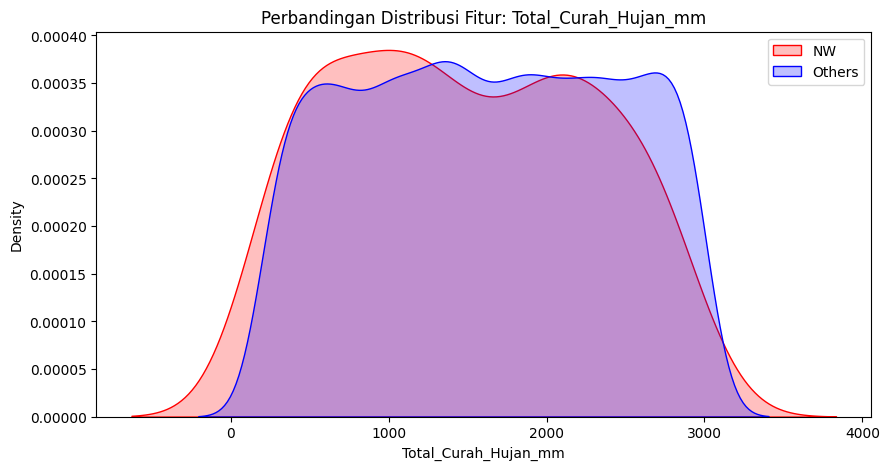

In [ ]:
# Analisis Distribusi Detail (NW vs Others)
print("\nEDA: Komparasi Statistik Detail 'North West' vs 'Others'...")

nw_key = "'North West'"

# Pastikan kolom Wilayah ada
if 'Wilayah' in train_df.columns:
    df_nw = train_df[train_df['Wilayah'] == nw_key].copy()
    df_others = train_df[train_df['Wilayah'] != nw_key].copy()

    if df_nw.empty:
        print(f"Peringatan: Wilayah '{nw_key}' tidak ditemukan di data training.")
    else:
        print(f"Data dipisahkan: NW ({len(df_nw)} baris), Others ({len(df_others)} baris)")

        # 1. Perbandingan Target
        print("\nPerbandingan Distribusi Target (Suhu_Rata_Rata_C):")
        stats_target_nw = df_nw['Suhu_Rata_Rata_C'].describe()
        stats_target_others = df_others['Suhu_Rata_Rata_C'].describe()
        compare_target = pd.DataFrame({'NW': stats_target_nw, 'Others': stats_target_others})
        print(compare_target.to_markdown(floatfmt=".2f"))

        # 2. Perbandingan Fitur Kunci
        features_to_compare = [
            'Total_Curah_Hujan_mm', 'Emisi_CO2_JT_Ton', 'Hasil_Panen_Ton_per_HA',
            'Indeks_Kesehatan_Tanah', 'Penggunaan_Pupuk_KG_per_HA',
            'Akses_Irigasi', 'Kejadian_Cuaca_Ekstrim'
        ]

        print("\nPerbandingan Statistik Fitur Kunci:")
        stats_nw_features = df_nw[features_to_compare].agg(['mean', 'std', 'median', 'skew']).T
        stats_others_features = df_others[features_to_compare].agg(['mean', 'std', 'median', 'skew']).T

        compare_features = pd.concat([stats_nw_features, stats_others_features], axis=1, keys=['NW', 'Others'])

        # Hitung perbedaan relatif
        std_others_safe = compare_features[('Others', 'std')].replace(0, 1e-6).fillna(1e-6)
        mean_diff_rel = (compare_features[('NW', 'mean')] - compare_features[('Others', 'mean')]) / std_others_safe
        compare_features[('Diff', 'Rel_Mean_Std')] = mean_diff_rel

        print(compare_features.sort_values(('Diff', 'Rel_Mean_Std'), key=abs, ascending=False).to_markdown(floatfmt=".2f"))

        # 3. Visualisasi Distribusi Fitur Paling Berbeda
        most_different_feature = compare_features.sort_values(('Diff', 'Rel_Mean_Std'), key=abs, ascending=False).index[0]
        print(f"\nVisualisasi fitur paling berbeda: {most_different_feature}")

        plt.figure(figsize=(10, 5))
        sns.kdeplot(df_nw[most_different_feature], color='red', label='NW', fill=True, clip_on=False)
        sns.kdeplot(df_others[most_different_feature], color='blue', label='Others', fill=True, clip_on=False)
        plt.title(f'Perbandingan Distribusi Fitur: {most_different_feature}')
        plt.legend()
        plt.show()

else:
    print("Kolom 'Wilayah' tidak ditemukan untuk analisis NW vs Others.")

In [ ]:
# Analisis Korelasi Internal (NW vs Others)

print("\nEDA: Analisis Perbedaan Korelasi Internal (NW vs Others)...")

if 'df_nw' in locals() and not df_nw.empty: # Cek apakah df_nw dari sel sebelumnya ada
    numeric_cols_all = train_df.select_dtypes(include=np.number).columns
    # Hapus ID dan kolom agregasi (jika ada, tapi di sini belum ada FE)
    numeric_cols_clean = [c for c in numeric_cols_all if c not in ['ID', 'Tahun']]

    corr_nw = df_nw[numeric_cols_clean].corr()
    corr_others = df_others[numeric_cols_clean].corr()

    # Hitung perbedaan absolut
    corr_diff = (corr_nw - corr_others).abs().fillna(0) # isi NaN (jika std=0) dengan 0

    # Cari pasangan dengan perbedaan terbesar
    corr_diff_flat = corr_diff.unstack().sort_values(ascending=False)
    corr_diff_flat = corr_diff_flat[corr_diff_flat.index.get_level_values(0) < corr_diff_flat.index.get_level_values(1)] # Hapus duplikat/diagonal

    print("Top 10 Perbedaan Korelasi Absolut Terbesar (NW vs Others):")
    top_diffs = corr_diff_flat.head(10)

    diff_summary = []
    for (f1, f2), diff_val in top_diffs.items():
         diff_summary.append({
              "Fitur 1": f1,
              "Fitur 2": f2,
              "Korelasi NW": corr_nw.loc[f1, f2],
              "Korelasi Others": corr_others.loc[f1, f2],
              "Perbedaan Abs": diff_val
         })
    print(pd.DataFrame(diff_summary).to_markdown(index=False, floatfmt=".2f"))

else:
    print("Data NW tidak terdefinisi. Lewati analisis korelasi internal.")


EDA: Menganalisis Perbedaan Korelasi Internal (NW vs Others)...
Top 10 Perbedaan Korelasi Absolut Terbesar (NW vs Others):
| Fitur 1                | Fitur 2                        |   Korelasi NW |   Korelasi Others |   Perbedaan Abs |
|:-----------------------|:-------------------------------|--------------:|------------------:|----------------:|
| Kejadian_Cuaca_Ekstrim | Penggunaan_Pestisida_KG_per_HA |          0.28 |              0.01 |            0.27 |
| Akses_Irigasi          | Indeks_Kesehatan_Tanah         |          0.22 |              0.00 |            0.22 |
| Kejadian_Cuaca_Ekstrim | Penggunaan_Pupuk_KG_per_HA     |         -0.15 |              0.02 |            0.16 |
| Indeks_Kesehatan_Tanah | Penggunaan_Pestisida_KG_per_HA |          0.15 |              0.01 |            0.14 |
| Akses_Irigasi          | Kejadian_Cuaca_Ekstrim         |          0.12 |             -0.01 |            0.13 |
| Suhu_Rata_Rata_C       | Total_Curah_Hujan_mm           |         -0.10 |   

ANALISIS SUHU PER WILAYAH (Setelah Dibersihkan)

Statistik Suhu per Wilayah:
                            count       mean        std   min    max
Wilayah                                                             
North Central                 196  13.054949  11.766778 -4.93  34.80
Punjab                        222  13.824775  11.371452 -4.81  34.97
Central                       370  14.411000  11.359378 -4.79  34.97
Maharashtra                   176  14.445966  11.437595 -4.68  34.72
British Columbia              210  14.481857  11.780099 -4.81  34.98
South East                    219  14.490959  11.667911 -4.84  34.84
East                          206  14.524369  11.301396 -4.99  34.98
Ile-de-France                 191  14.650314  11.352951 -4.78  34.58
Siberian                      196  14.715816  12.173728 -4.97  34.79
Volga                         210  14.771000  11.493992 -4.83  34.89
Patagonia                     194  14.771649  11.120647 -4.70  34.94
Pampas                    

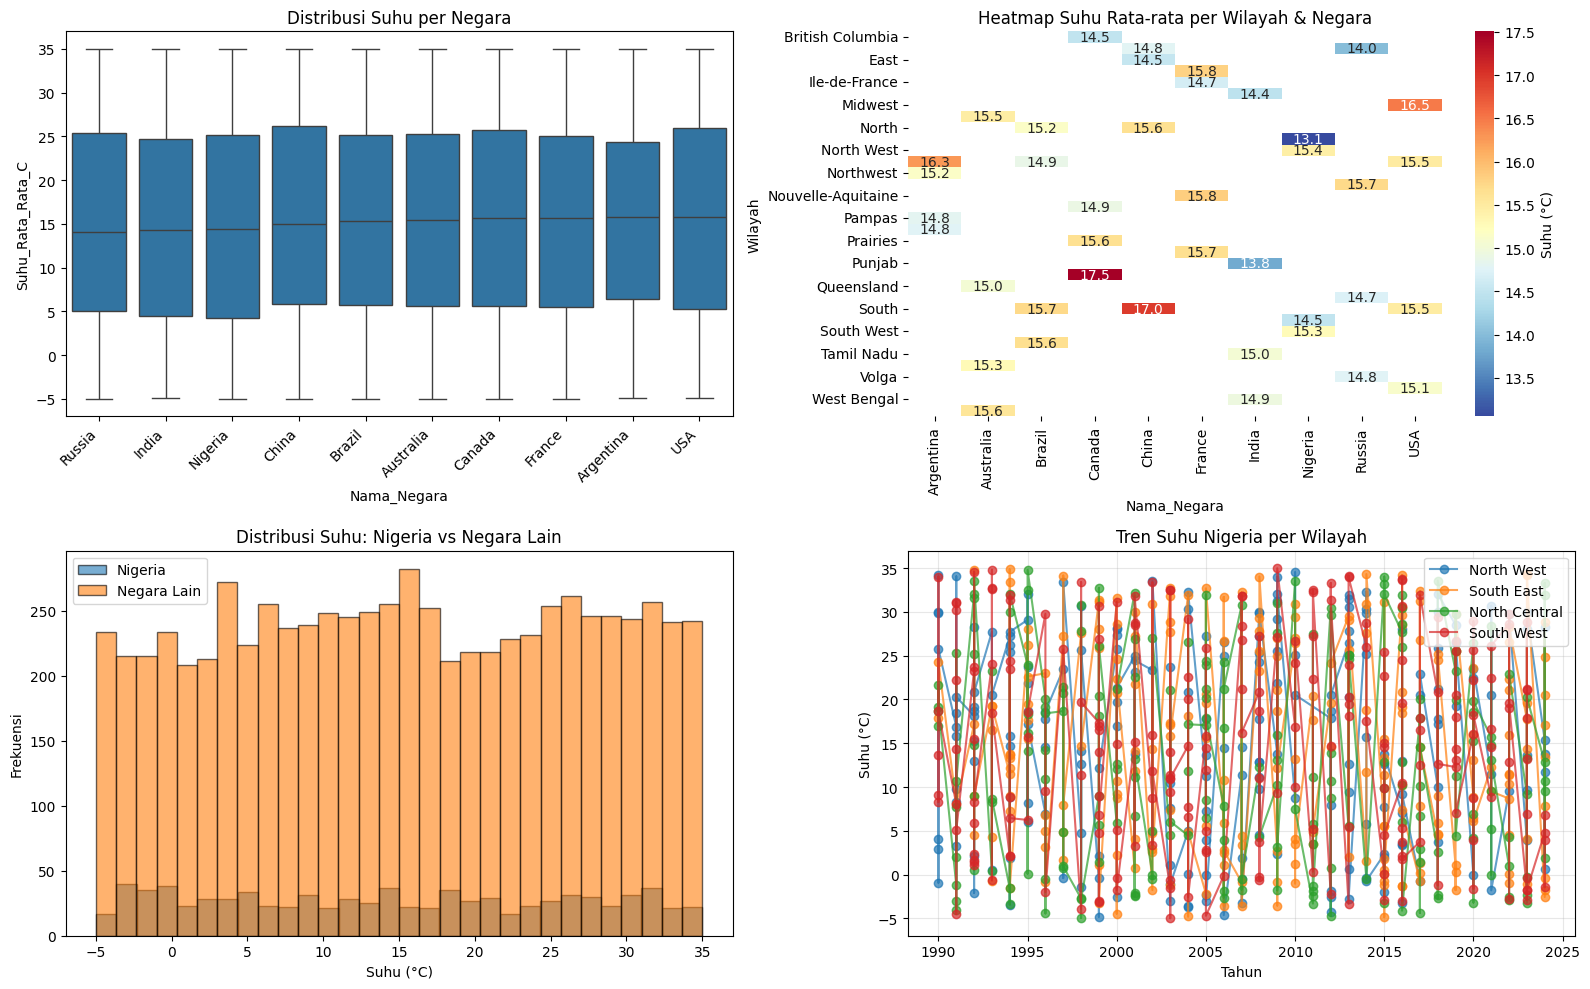


ANALISIS DETAIL: NORTH WEST (Nigeria)

Jumlah data North West: 201
Rentang tahun: 1990 - 2024

Statistik Suhu North West:
count    201.000000
mean      15.437960
std       11.500292
min       -4.790000
25%        4.810000
50%       15.870000
75%       25.730000
max       34.510000
Name: Suhu_Rata_Rata_C, dtype: float64

Perbandingan dengan Nigeria wilayah lain:
Mean North West: 15.44°C
Mean Nigeria Lainnya: 14.30°C
Selisih: 1.14°C

T-test: t=1.2046, p-value=0.228713
Signifikan berbeda: TIDAK


In [ ]:
# Analisis Suhu per Wilayah (after Cleaned)

train_df['Wilayah'] = train_df['Wilayah'].str.replace("'", "", regex=False)
test_df['Wilayah'] = test_df['Wilayah'].str.replace("'", "", regex=False)

print("="*80)
print("ANALISIS SUHU PER WILAYAH (Setelah Dibersihkan)")
print("="*80)

# Analisis statistik per wilayah
wilayah_stats = train_df.groupby('Wilayah')['Suhu_Rata_Rata_C'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).sort_values('mean')

print("\nStatistik Suhu per Wilayah:")
print(wilayah_stats)

# Cari wilayah dengan pola anomali
print("\n" + "="*80)
print("DETEKSI WILAYAH ANOMALI")
print("="*80)

# Kriteria anomali:
# 1. Mean suhu sangat berbeda dari median global
# 2. Std sangat tinggi/rendah
# 3. Min/Max ekstrem

global_mean = train_df['Suhu_Rata_Rata_C'].mean()
global_std = train_df['Suhu_Rata_Rata_C'].std()

print(f"\nSuhu Global: Mean={global_mean:.2f}°C, Std={global_std:.2f}°C")

anomalous_regions = []
for wilayah in train_df['Wilayah'].unique():
    wilayah_data = train_df[train_df['Wilayah'] == wilayah]['Suhu_Rata_Rata_C']
    wilayah_mean = wilayah_data.mean()
    wilayah_std = wilayah_data.std()

    # Deteksi anomali: mean berbeda >1.5 std dari global
    if abs(wilayah_mean - global_mean) > 1.5 * global_std:
        anomalous_regions.append({
            'Wilayah': wilayah,
            'Mean': wilayah_mean,
            'Std': wilayah_std,
            'Deviasi dari Global': wilayah_mean - global_mean
        })

if anomalous_regions:
    print("\n🚨 WILAYAH ANOMALI TERDETEKSI:")
    anomaly_df = pd.DataFrame(anomalous_regions).sort_values('Deviasi dari Global')
    print(anomaly_df)
else:
    print("\n✅ Tidak ada wilayah dengan anomali ekstrem")

# Visualisasi distribusi suhu per negara
print("\n" + "="*80)
print("VISUALISASI DISTRIBUSI SUHU")
print("="*80)

plt.figure(figsize=(16, 10))

# Subplot 1: Boxplot per negara
plt.subplot(2, 2, 1)
negara_order = train_df.groupby('Nama_Negara')['Suhu_Rata_Rata_C'].median().sort_values().index
sns.boxplot(data=train_df, x='Nama_Negara', y='Suhu_Rata_Rata_C', order=negara_order)
plt.xticks(rotation=45, ha='right')
plt.title('Distribusi Suhu per Negara')
plt.tight_layout()

# Subplot 2: Heatmap suhu per negara & wilayah
plt.subplot(2, 2, 2)
pivot_temp = train_df.pivot_table(values='Suhu_Rata_Rata_C',
                                   index='Wilayah',
                                   columns='Nama_Negara',
                                   aggfunc='mean')
sns.heatmap(pivot_temp, cmap='RdYlBu_r', center=global_mean,
            annot=True, fmt='.1f', cbar_kws={'label': 'Suhu (°C)'})
plt.title('Heatmap Suhu Rata-rata per Wilayah & Negara')
plt.tight_layout()

# Subplot 3: Histogram Nigeria vs Negara Lain
plt.subplot(2, 2, 3)
nigeria_temp = train_df[train_df['Nama_Negara'] == 'Nigeria']['Suhu_Rata_Rata_C']
others_temp = train_df[train_df['Nama_Negara'] != 'Nigeria']['Suhu_Rata_Rata_C']
plt.hist(nigeria_temp, bins=30, alpha=0.6, label='Nigeria', edgecolor='black')
plt.hist(others_temp, bins=30, alpha=0.6, label='Negara Lain', edgecolor='black')
plt.xlabel('Suhu (°C)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Suhu: Nigeria vs Negara Lain')
plt.legend()
plt.tight_layout()

# Subplot 4: Tren suhu Nigeria per wilayah
plt.subplot(2, 2, 4)
nigeria_data = train_df[train_df['Nama_Negara'] == 'Nigeria']
for wilayah in nigeria_data['Wilayah'].unique():
    wilayah_data = nigeria_data[nigeria_data['Wilayah'] == wilayah]
    wilayah_data = wilayah_data.sort_values('Tahun')
    plt.plot(wilayah_data['Tahun'], wilayah_data['Suhu_Rata_Rata_C'],
             marker='o', label=wilayah, alpha=0.7)
plt.xlabel('Tahun')
plt.ylabel('Suhu (°C)')
plt.title('Tren Suhu Nigeria per Wilayah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# Analisis khusus North West
print("\n" + "="*80)
print("ANALISIS DETAIL: NORTH WEST (Nigeria)")
print("="*80)

nw_data = train_df[(train_df['Nama_Negara'] == 'Nigeria') &
                   (train_df['Wilayah'] == 'North West')]

print(f"\nJumlah data North West: {len(nw_data)}")
print(f"Rentang tahun: {nw_data['Tahun'].min()} - {nw_data['Tahun'].max()}")
print(f"\nStatistik Suhu North West:")
print(nw_data['Suhu_Rata_Rata_C'].describe())

print(f"\nPerbandingan dengan Nigeria wilayah lain:")
nigeria_others = train_df[(train_df['Nama_Negara'] == 'Nigeria') &
                          (train_df['Wilayah'] != 'North West')]
print(f"Mean North West: {nw_data['Suhu_Rata_Rata_C'].mean():.2f}°C")
print(f"Mean Nigeria Lainnya: {nigeria_others['Suhu_Rata_Rata_C'].mean():.2f}°C")
print(f"Selisih: {nw_data['Suhu_Rata_Rata_C'].mean() - nigeria_others['Suhu_Rata_Rata_C'].mean():.2f}°C")

# T-test untuk signifikansi
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(nw_data['Suhu_Rata_Rata_C'],
                             nigeria_others['Suhu_Rata_Rata_C'])
print(f"\nT-test: t={t_stat:.4f}, p-value={p_value:.6f}")
print(f"Signifikan berbeda: {'YA' if p_value < 0.05 else 'TIDAK'}")


CEK KARDINALITAS Fitur Kategorikal
Nama_Negara: 10 kategori unik
  -> Distribusi: {'USA': 831, 'Nigeria': 826, 'Australia': 826, 'China': 823, 'India': 818, 'Canada': 801, 'Argentina': 772, 'Russia': 771, 'France': 771, 'Brazil': 761}
Wilayah: 34 kategori unik
Jenis_Tanaman: 10 kategori unik
  -> Distribusi: {'Wheat': 819, 'Cotton': 801, 'Vegetables': 791, 'Corn': 789, 'Rice': 782, 'Barley': 776, 'Sugarcane': 776, 'Fruits': 758, 'Coffee': 755, 'Soybeans': 734}
Strategi_Adaptasi: 5 kategori unik
  -> Distribusi: {'Manajemen Air': 1647, 'Rotasi Tanaman': 1589, 'Tanpa Adaptasi': 1589, 'Pertanian Organik': 1588, 'Tanaman Tahan Kekeringan': 1587}

CEK SKEWNESS (Kemiringan) Fitur Numerik
                          Feature  Skewness  Status
3          Hasil_Panen_Ton_per_HA  0.345230  Normal
7      Penggunaan_Pupuk_KG_per_HA  0.022531  Normal
8          Indeks_Kesehatan_Tanah  0.016158  Normal
4          Kejadian_Cuaca_Ekstrim  0.009846  Normal
2                Emisi_CO2_JT_Ton  0.005556  Nor

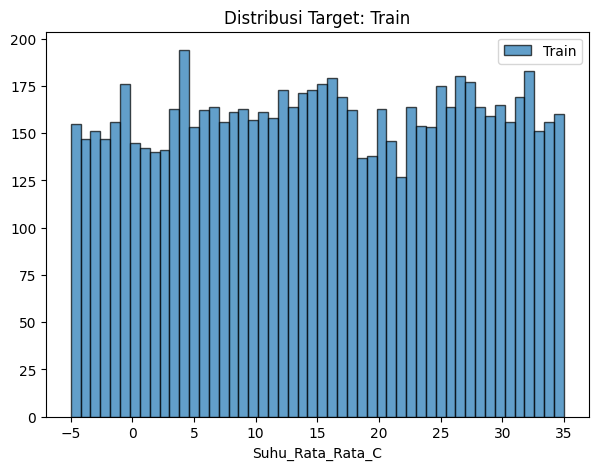

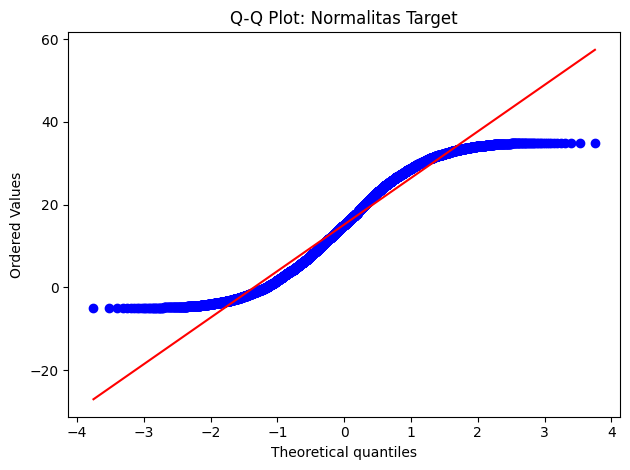

In [ ]:
# CEK KARDINALITAS Fitur Kategorikal
print("\nCEK KARDINALITAS Fitur Kategorikal")
numerical_features = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('ID')
cat_cols = train_df.select_dtypes(exclude=np.number).columns.tolist()
for col in cat_cols:
    unique_count = train_df[col].nunique()
    print(f"{col}: {unique_count} kategori unik")
    if unique_count <= 10:
        print(f"  -> Distribusi: {train_df[col].value_counts().to_dict()}")

# CEK SKEWNESS (Kemiringan) Fitur Numerik
print("\nCEK SKEWNESS (Kemiringan) Fitur Numerik")
skewness_data = []
for col in numerical_features:
    if col != 'Suhu_Rata_Rata_C':
        skew_val = train_df[col].skew()
        skewness_data.append({'Feature': col, 'Skewness': skew_val,
                              'Status': 'Miring' if abs(skew_val) > 1 else 'Normal'})

skewness_df = pd.DataFrame(skewness_data).sort_values('Skewness', ascending=False)
print(skewness_df)

# CEK DISTRIBUSI TARGET: Train vs Test
print("\nCEK DISTRIBUSI TARGET: Train")
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
axes.hist(train_df['Suhu_Rata_Rata_C'].dropna(), bins=50, alpha=0.7, label='Train', edgecolor='black')
axes.set_title('Distribusi Target: Train')
axes.set_xlabel('Suhu_Rata_Rata_C')
axes.legend()

# Statistik perbandingan
stats_comparison = pd.DataFrame({
    'Train': train_df['Suhu_Rata_Rata_C'].describe(),
})
print("\nStatistik Perbandingan Train:")
print(stats_comparison)

# Q-Q plot
from scipy.stats import probplot
probplot(train_df['Suhu_Rata_Rata_C'].dropna(), dist="norm", plot=plt.figure().add_subplot(111))
plt.title('Q-Q Plot: Normalitas Target')
plt.tight_layout()
plt.show()

## Feature Engineering, Preprocessing, and Modeling

#### SUBMISI 1

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import KFold # Import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer # Hanya untuk OHE
from sklearn.pipeline import Pipeline # Hanya untuk OHE
from sklearn.impute import SimpleImputer # Untuk handle NaN OHE
from sklearn.metrics import mean_absolute_error
from itertools import combinations
import warnings
import sys
import gc # Garbage collector

# --- 1. Fungsi Metrik & Pembantu ---
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

def normalize_id_column(df):
    if 'id' in df.columns: return df.rename(columns={'id': 'ID'})
    return df

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) == 0: return np.inf
    epsilon = 1e-9
    denominator = np.maximum(np.abs(y_true[non_zero_mask]), epsilon)
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / denominator)) * 100

def create_mape_weights(y, max_weight=20.0):
    weights = 1.0 / (np.abs(y) + 1e-6)
    clipped_weights = np.clip(weights, None, max_weight)
    return clipped_weights

# --- 2. Kumpulan Fungsi FE (Versi Diperkaya) ---
# (Pastikan ini MENCERMINKAN 'the Best.ipynb' seakurat mungkin)
def create_temporal_features(df):
    df_copy = df.copy()
    if 'Tahun' in df_copy.columns:
        df_copy['Tahun_Sejak_Mulai'] = df_copy['Tahun'] - df_copy['Tahun'].min()
    return df_copy

def create_interaction_features(df):
    df_copy = df.copy()
    interactions = [
        ('Penggunaan_Pupuk_KG_per_HA', 'Total_Curah_Hujan_mm', 'Pupuk_x_Hujan'),
        ('Penggunaan_Pestisida_KG_per_HA', 'Total_Curah_Hujan_mm', 'Pestisida_x_Hujan'),
        ('Penggunaan_Pestisida_KG_per_HA', 'Penggunaan_Pupuk_KG_per_HA', 'Pestisida_x_Pupuk'),
        ('Emisi_CO2_JT_Ton', 'Hasil_Panen_Ton_per_HA', 'CO2_x_Panen')
        # Tambahkan interaksi lain dari 'the Best' jika ada
    ]
    for col1, col2, new_col in interactions:
        if all(c in df_copy.columns for c in [col1, col2]):
            df_copy[new_col] = df_copy[col1] * df_copy[col2]
    return df_copy

def create_ratio_features(df):
    df_copy = df.copy()
    ratios = [
        ('Penggunaan_Pupuk_KG_per_HA', 'Penggunaan_Pestisida_KG_per_HA', 'Rasio_Pupuk_Pestisida'),
        ('Emisi_CO2_JT_Ton', 'Hasil_Panen_Ton_per_HA', 'CO2_per_Panen')
    ]
    for num, den, new_col in ratios:
        if all(c in df_copy.columns for c in [num, den]):
            df_copy[new_col] = df_copy[num] / (df_copy[den] + 1e-6)
    return df_copy

def create_polynomial_features(df):
    df_copy = df.copy()
    poly_cols = ['Emisi_CO2_JT_Ton', 'Total_Curah_Hujan_mm']
    for col in poly_cols:
        if col in df_copy.columns:
            df_copy[f'{col}_pangkat_2'] = df_copy[col]**2
    return df_copy

def create_geo_aggregation_features(df_train, df_test):
    # (Fungsi ini sama seperti sebelumnya, pastikan keys_to_agg = ['Nama_Negara', 'Wilayah'])
    df_train_copy, df_test_copy = df_train.copy(), df_test.copy()
    keys_to_agg = ['Nama_Negara', 'Wilayah'] # Sesuai analisis 'the Best'
    for group_key in keys_to_agg:
        if group_key not in df_train_copy.columns: continue
        geo_agg_feats = {'Total_Curah_Hujan_mm': ['mean', 'std'], 'Emisi_CO2_JT_Ton': ['mean', 'std'], 'Hasil_Panen_Ton_per_HA': ['mean', 'std'], 'Indeks_Kesehatan_Tanah': ['mean']}
        print(f"  Membuat agregasi per: {group_key}...")
        for col, aggs in geo_agg_feats.items():
            if col in df_train_copy.columns:
                for agg in aggs:
                    new_col_name = f'{group_key}_{col}_{agg}'
                    try: # Tambah error handling
                        agg_map = df_train_copy.groupby(group_key, observed=False)[col].agg(agg) # observed=False penting
                        df_train_copy[new_col_name] = df_train_copy[group_key].map(agg_map)
                        df_test_copy[new_col_name] = df_test_copy[group_key].map(agg_map)
                        global_mean = df_train_copy[col].mean()
                        df_test_copy[new_col_name].fillna(global_mean, inplace=True)
                    except Exception as e:
                        print(f"    Warning: Gagal agregasi {new_col_name} - {e}")

        for col in ['Total_Curah_Hujan_mm', 'Emisi_CO2_JT_Ton']:
            mean_col = f'{group_key}_{col}_mean'
            if mean_col in df_train_copy.columns and col in df_train_copy.columns:
                df_train_copy[f'Diff_{col}_dari_Rata2_{group_key}'] = df_train_copy[col] - df_train_copy[mean_col]
                if mean_col in df_test_copy.columns and col in df_test_copy.columns:
                     df_test_copy[f'Diff_{col}_dari_Rata2_{group_key}'] = df_test_copy[col] - df_test_copy[mean_col]
                else:
                     df_test_copy[f'Diff_{col}_dari_Rata2_{group_key}'] = 0
    return df_train_copy, df_test_copy


def apply_all_feature_engineering(train_df, test_df):
    print("  Memulai apply_all_feature_engineering...")
    fe_funcs_row_wise = [create_temporal_features, create_interaction_features, create_ratio_features, create_polynomial_features]
    train_df_fe, test_df_fe = train_df.copy(), test_df.copy()
    for func in fe_funcs_row_wise:
        train_df_fe = func(train_df_fe)
        test_df_fe = func(test_df_fe)
    train_df_fe, test_df_fe = create_geo_aggregation_features(train_df_fe, test_df_fe)
    print(f"  Feature Engineering selesai. Shape train: {train_df_fe.shape}, test: {test_df_fe.shape}")
    return train_df_fe, test_df_fe
# --- >>> AKHIR DARI BLOK FUNGSI FE <<< ---

# --- 3. Fungsi Objective (Tuning XGBoost) - KFold CV ---
# Variabel global untuk data (kurangi passing parameter)
X_test_ohe_global = None # Keep X_test_ohe_global for final prediction
test_ids_global = None # Keep test_ids_global for final submission
X_train_ohe_global = None
y_train_global = None
train_indices_nw = None
train_indices_others = None
test_indices_nw = None # Keep test_indices_nw for final prediction
test_indices_others = None # Keep test_indices_others for final prediction


def objective_xgb_kfold(trial, group):
    """ Objective for Optuna, KFold Cross-Validation based on MAPE. """
    params = {
        'objective': 'reg:absoluteerror', 'eval_metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'lambda': trial.suggest_float('lambda', 1e-6, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-6, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 1e-6, 1.0, log=True),
        'seed': trial.suggest_int('seed', 1, 100),
        'n_jobs': -1,
    }
    max_weight_clip = trial.suggest_float('max_weight', 10.0, 40.0)

    # Select training data indices based on group
    if group == 'NW':
        train_indices = train_indices_nw
    else: # Others
        train_indices = train_indices_others

    X_train_group = X_train_ohe_global.iloc[train_indices]
    y_train_group = y_train_global.iloc[train_indices]

    # KFold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    try:
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_group, y_train_group)):
            X_fold_train, X_fold_val = X_train_group.iloc[train_idx], X_train_group.iloc[val_idx]
            y_fold_train, y_fold_val = y_train_group.iloc[train_idx], y_train_group.iloc[val_idx]

            sample_weight = create_mape_weights(y_fold_train, max_weight=max_weight_clip)

            model = xgb.XGBRegressor(**params)
            # FIX: Gunakan y_fold_train bukan y_fold_val untuk training
            model.fit(X_fold_train, y_fold_train, sample_weight=sample_weight, verbose=False)

            preds_val = model.predict(X_fold_val)
            fold_mape = calculate_mape(y_fold_val, preds_val)
            mape_scores.append(fold_mape)

        avg_mape = np.mean(mape_scores)
        return avg_mape

    except Exception as e:
        print(f"Error in Optuna trial {group}: {e}")
        return np.inf


# --- 4. Orkestrator Utama (Spesialis NW vs Others + OHE + Optuna KFold) ---

def run_specialist_optimization_kfold(n_trials_per_group=75): # Kurangi trials awal?
    global X_test_ohe_global, test_ids_global, \
           X_train_ohe_global, y_train_global, \
           train_indices_nw, train_indices_others, \
           test_indices_nw, test_indices_others # Keep test indices

    print("Memuat data...")
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
    except FileNotFoundError as e: print(f"Error: Gagal memuat file. Detail: {e}"); return

    train_df, test_df = map(normalize_id_column, [train_df, test_df])
    test_ids_global = test_df['ID'].copy()


    # 2. Feature Engineering
    print("Menjalankan Feature Engineering...")
    y_train_global = train_df['Suhu_Rata_Rata_C']
    X_train_orig = train_df.drop(['Suhu_Rata_Rata_C', 'ID'], axis=1, errors='ignore')
    X_test_orig = test_df.drop('ID', axis=1, errors='ignore') # Keep original test for index alignment
    X_train_fe, X_test_fe = apply_all_feature_engineering(X_train_orig, X_test_orig)

    # --- 3. OneHotEncoding ---
    print("Menjalankan OneHotEncoding...")
    categorical_features = X_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_features = X_train_fe.select_dtypes(include=np.number).columns.tolist()

    # Buat preprocessor OHE
    ohe_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', ohe_pipeline, categorical_features)
        ],
        remainder='passthrough'
    )

    preprocessor.fit(X_train_fe[categorical_features + numeric_features])

    X_train_ohe = preprocessor.transform(X_train_fe[categorical_features + numeric_features])
    X_test_ohe = preprocessor.transform(X_test_fe[categorical_features + numeric_features])

    try:
         ohe_feature_names = preprocessor.get_feature_names_out()
         ohe_feature_names = [name.split('__')[-1] for name in ohe_feature_names]

    except AttributeError:
         print("Warning: Versi sklearn < 1.0, nama fitur OHE mungkin kurang deskriptif.")
         ohe_feature_names = preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
         ohe_feature_names.extend(numeric_features)


    X_train_ohe_global = pd.DataFrame(X_train_ohe, columns=ohe_feature_names, index=X_train_fe.index)
    X_test_ohe_global = pd.DataFrame(X_test_ohe, columns=ohe_feature_names, index=X_test_fe.index) # Assign to global
    print(f"OneHotEncoding selesai. Shape train: {X_train_ohe_global.shape}, test: {X_test_ohe_global.shape}")


    # --- 4. Tentukan Indeks NW vs Others (for training & final prediction) ---
    nw_key = "'North West'"
    if 'Wilayah' not in train_df.columns or 'Wilayah' not in test_df.columns:
        print("Error: Kolom 'Wilayah' asli tidak ditemukan. Tidak bisa memisahkan NW/Others.")
        return

    train_indices_nw = train_df[train_df['Wilayah'] == nw_key].index
    train_indices_others = train_df[train_df['Wilayah'] != nw_key].index
    # Keep test indices for final merging
    test_indices_nw = test_df[test_df['Wilayah'] == nw_key].index
    test_indices_others = test_df[test_df['Wilayah'] != nw_key].index


    print(f"Data dipisahkan: Train NW({len(train_indices_nw)}), Train Others({len(train_indices_others)}), Test NW({len(test_indices_nw)}), Test Others({len(test_indices_others)})")


    # --- 5. Optimasi Terpisah (Using KFold Objective) ---
    print(f"\nMemulai optimasi XGB 'Others' ({n_trials_per_group} percobaan) - Validasi KFold...")
    study_others = optuna.create_study(direction='minimize')
    study_others.optimize(lambda trial: objective_xgb_kfold(trial, 'Others'), n_trials=n_trials_per_group)

    print(f"\nMemulai optimasi XGB 'NW' ({n_trials_per_group} percobaan) - Validasi KFold...")
    study_nw = optuna.create_study(direction='minimize')
    study_nw.optimize(lambda trial: objective_xgb_kfold(trial, 'NW'), n_trials=n_trials_per_group)


    print("\nOptimasi Selesai (berdasarkan skor MAPE KFold CV per grup).")
    print(f"  'Others' KFold MAPE Terbaik (Obj:MAE): {study_others.best_value:.4f}")
    print(f"  'NW' KFold MAPE Terbaik (Obj:MAE): {study_nw.best_value:.4f}")

    # --- 6. Latih Model Final Spesialis ---
    print("\nMelatih model final spesialis pada data training masing-masing...")
    best_params_others = study_others.best_params
    best_params_nw = study_nw.best_params

    # Remove max_weight from params passed to XGBoost constructor, use in fit
    best_max_weight_others = best_params_others.pop('max_weight', 20.0)
    best_max_weight_nw = best_params_nw.pop('max_weight', 20.0)


    final_model_others = xgb.XGBRegressor(objective='reg:absoluteerror', eval_metric='mae', **best_params_others, n_jobs=-1)
    final_model_nw = xgb.XGBRegressor(objective='reg:absoluteerror', eval_metric='mae', **best_params_nw, n_jobs=-1)

    X_train_others_final = X_train_ohe_global.iloc[train_indices_others]
    y_train_others_final = y_train_global.iloc[train_indices_others]
    X_train_nw_final = X_train_ohe_global.iloc[train_indices_nw]
    y_train_nw_final = y_train_global.iloc[train_indices_nw]

    weights_others = create_mape_weights(y_train_others_final, max_weight=best_max_weight_others)
    weights_nw = create_mape_weights(y_train_nw_final, max_weight=best_max_weight_nw)


    final_model_others.fit(X_train_others_final, y_train_others_final, sample_weight=weights_others)
    print("  Model Others selesai dilatih.")
    final_model_nw.fit(X_train_nw_final, y_train_nw_final, sample_weight=weights_nw)
    print("  Model NW selesai dilatih.")

    # --- 7. Prediksi & Gabungkan Hasil ---
    print("Membuat prediksi pada data test using specialist models...")
    # Use global X_test_ohe_global and test indices
    X_test_others_final = X_test_ohe_global.iloc[test_indices_others]
    X_test_nw_final = X_test_ohe_global.iloc[test_indices_nw]


    preds_others = final_model_others.predict(X_test_others_final)
    preds_nw = final_model_nw.predict(X_test_nw_final)

    # Gabungkan prediksi kembali ke urutan asli test_df
    final_predictions = pd.Series(index=X_test_ohe_global.index, dtype=float)
    final_predictions.iloc[test_indices_others] = preds_others
    final_predictions.iloc[test_indices_nw] = preds_nw
    # Fill any potential NaNs (shouldn't be any if indices are correct)
    final_predictions.fillna(y_train_global.mean(), inplace=True)


    submission_df = pd.DataFrame({'ID': test_ids_global, 'Suhu_Rata_Rata_C': final_predictions})
    submission_df.rename(columns={'ID': 'id'}, inplace=True)
    submission_df.to_csv('submission_specialist_xgb_ohe_kfold.csv', index=False) # Renamed output file
    print("File 'submission_specialist_xgb_ohe_kfold.csv' berhasil dibuat.")

    print("\nFinal submission created. Evaluation metric was KFold MAPE during tuning.")


    gc.collect() # Bersihkan memori

if __name__ == '__main__':
    run_specialist_optimization_kfold(n_trials_per_group=50) # Reduced trials for testing

Output streaming akan dipotong hingga 5000 baris terakhir.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

#### SUBMISI 2

In [ ]:
import optuna
from sklearn.model_selection import KFold # Import KFold
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer # Hanya untuk OHE
from sklearn.pipeline import Pipeline # Hanya untuk OHE
from sklearn.impute import SimpleImputer # Untuk handle NaN OHE
from sklearn.metrics import mean_absolute_error
from itertools import combinations
import warnings
import sys
import gc # Garbage collector

# --- 1. Fungsi Metrik & Pembantu ---
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

def normalize_id_column(df):
    if 'id' in df.columns: return df.rename(columns={'id': 'ID'})
    return df

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) == 0: return np.inf
    epsilon = 1e-9
    denominator = np.maximum(np.abs(y_true[non_zero_mask]), epsilon)
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / denominator)) * 100

def create_mape_weights(y, max_weight=20.0):
    weights = 1.0 / (np.abs(y) + 1e-6)
    clipped_weights = np.clip(weights, None, max_weight)
    return clipped_weights

# --- 2. Kumpulan Fungsi FE (Versi Diperkaya) ---
# (Pastikan ini MENCERMINKAN 'the Best.ipynb' seakurat mungkin)
def create_temporal_features(df):
    df_copy = df.copy()
    if 'Tahun' in df_copy.columns:
        df_copy['Tahun_Sejak_Mulai'] = df_copy['Tahun'] - df_copy['Tahun'].min()
    return df_copy

def create_interaction_features(df):
    df_copy = df.copy()
    interactions = [
        ('Penggunaan_Pupuk_KG_per_HA', 'Total_Curah_Hujan_mm', 'Pupuk_x_Hujan'),
        ('Penggunaan_Pestisida_KG_per_HA', 'Total_Curah_Hujan_mm', 'Pestisida_x_Hujan'),
        ('Penggunaan_Pestisida_KG_per_HA', 'Penggunaan_Pupuk_KG_per_HA', 'Pestisida_x_Pupuk'),
        ('Emisi_CO2_JT_Ton', 'Hasil_Panen_Ton_per_HA', 'CO2_x_Panen')
        # Tambahkan interaksi lain dari 'the Best' jika ada
    ]
    for col1, col2, new_col in interactions:
        if all(c in df_copy.columns for c in [col1, col2]):
            df_copy[new_col] = df_copy[col1] * df_copy[col2]
    return df_copy

def create_ratio_features(df):
    df_copy = df.copy()
    ratios = [
        ('Penggunaan_Pupuk_KG_per_HA', 'Penggunaan_Pestisida_KG_per_HA', 'Rasio_Pupuk_Pestisida'),
        ('Emisi_CO2_JT_Ton', 'Hasil_Panen_Ton_per_HA', 'CO2_per_Panen')
    ]
    for num, den, new_col in ratios:
        if all(c in df_copy.columns for c in [num, den]):
            df_copy[new_col] = df_copy[num] / (df_copy[den] + 1e-6)
    return df_copy

def create_polynomial_features(df):
    df_copy = df.copy()
    poly_cols = ['Emisi_CO2_JT_Ton', 'Total_Curah_Hujan_mm']
    for col in poly_cols:
        if col in df_copy.columns:
            df_copy[f'{col}_pangkat_2'] = df_copy[col]**2
    return df_copy

def create_geo_aggregation_features(df_train, df_test):
    # (Fungsi ini sama seperti sebelumnya, pastikan keys_to_agg = ['Nama_Negara', 'Wilayah'])
    df_train_copy, df_test_copy = df_train.copy(), df_test.copy()
    keys_to_agg = ['Nama_Negara', 'Wilayah'] # Sesuai analisis 'the Best'
    for group_key in keys_to_agg:
        if group_key not in df_train_copy.columns: continue
        geo_agg_feats = {'Total_Curah_Hujan_mm': ['mean', 'std'], 'Emisi_CO2_JT_Ton': ['mean', 'std'], 'Hasil_Panen_Ton_per_HA': ['mean', 'std'], 'Indeks_Kesehatan_Tanah': ['mean']}
        print(f"  Membuat agregasi per: {group_key}...")
        for col, aggs in geo_agg_feats.items():
            if col in df_train_copy.columns:
                for agg in aggs:
                    new_col_name = f'{group_key}_{col}_{agg}'
                    try: # Tambah error handling
                        agg_map = df_train_copy.groupby(group_key, observed=False)[col].agg(agg) # observed=False penting
                        df_train_copy[new_col_name] = df_train_copy[group_key].map(agg_map)
                        df_test_copy[new_col_name] = df_test_copy[group_key].map(agg_map)
                        global_mean = df_train_copy[col].mean()
                        df_test_copy[new_col_name].fillna(global_mean, inplace=True)
                    except Exception as e:
                        print(f"    Warning: Gagal agregasi {new_col_name} - {e}")

        for col in ['Total_Curah_Hujan_mm', 'Emisi_CO2_JT_Ton']:
            mean_col = f'{group_key}_{col}_mean'
            if mean_col in df_train_copy.columns and col in df_train_copy.columns:
                df_train_copy[f'Diff_{col}_dari_Rata2_{group_key}'] = df_train_copy[col] - df_train_copy[mean_col]
                if mean_col in df_test_copy.columns and col in df_test_copy.columns:
                     df_test_copy[f'Diff_{col}_dari_Rata2_{group_key}'] = df_test_copy[col] - df_test_copy[mean_col]
                else:
                     df_test_copy[f'Diff_{col}_dari_Rata2_{group_key}'] = 0
    return df_train_copy, df_test_copy


def apply_all_feature_engineering(train_df, test_df):
    print("  Memulai apply_all_feature_engineering...")
    fe_funcs_row_wise = [create_temporal_features, create_interaction_features, create_ratio_features, create_polynomial_features]
    train_df_fe, test_df_fe = train_df.copy(), test_df.copy()
    for func in fe_funcs_row_wise:
        train_df_fe = func(train_df_fe)
        test_df_fe = func(test_df_fe)
    train_df_fe, test_df_fe = create_geo_aggregation_features(train_df_fe, test_df_fe)
    print(f"  Feature Engineering selesai. Shape train: {train_df_fe.shape}, test: {test_df_fe.shape}")
    return train_df_fe, test_df_fe
# --- >>> AKHIR DARI BLOK FUNGSI FE <<< ---

# --- 3. Fungsi Objective (Tuning XGBoost) - KFold CV ---
# Variabel global untuk data (kurangi passing parameter)
X_test_ohe_global = None # Keep X_test_ohe_global for final prediction
test_ids_global = None # Keep test_ids_global for final submission
X_train_ohe_global = None
y_train_global = None
train_indices_nw = None
train_indices_others = None
test_indices_nw = None # Keep test_indices_nw for final prediction
test_indices_others = None # Keep test_indices_others for final prediction


def objective_xgb_kfold(trial, group):
    """ Objective for Optuna, KFold Cross-Validation based on MAPE. """
    params = {
        'objective': 'reg:absoluteerror', 'eval_metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'lambda': trial.suggest_float('lambda', 1e-6, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-6, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 1e-6, 1.0, log=True),
        'seed': trial.suggest_int('seed', 1, 100),
        'n_jobs': -1,
    }
    max_weight_clip = trial.suggest_float('max_weight', 10.0, 40.0)

    # Select training data indices based on group
    if group == 'NW':
        train_indices = train_indices_nw
    else: # Others
        train_indices = train_indices_others

    X_train_group = X_train_ohe_global.iloc[train_indices]
    y_train_group = y_train_global.iloc[train_indices]

    # KFold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    try:
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_group, y_train_group)):
            X_fold_train, X_fold_val = X_train_group.iloc[train_idx], X_train_group.iloc[val_idx]
            y_fold_train, y_fold_val = y_train_group.iloc[train_idx], y_train_group.iloc[val_idx]

            sample_weight = create_mape_weights(y_fold_train, max_weight=max_weight_clip)

            model = xgb.XGBRegressor(**params)
            # FIX: Gunakan y_fold_train bukan y_fold_val untuk training
            model.fit(X_fold_train, y_fold_train, sample_weight=sample_weight, verbose=False)

            preds_val = model.predict(X_fold_val)
            fold_mape = calculate_mape(y_fold_val, preds_val)
            mape_scores.append(fold_mape)

        avg_mape = np.mean(mape_scores)
        return avg_mape

    except Exception as e:
        print(f"Error in Optuna trial {group}: {e}")
        return np.inf


# --- 4. Orkestrator Utama (Spesialis NW vs Others + OHE + Optuna KFold) ---

def run_specialist_optimization_kfold(n_trials_per_group=75): # Kurangi trials awal?
    global X_test_ohe_global, test_ids_global, \
           X_train_ohe_global, y_train_global, \
           train_indices_nw, train_indices_others, \
           test_indices_nw, test_indices_others # Keep test indices

    print("Memuat data...")
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
    except FileNotFoundError as e: print(f"Error: Gagal memuat file. Detail: {e}"); return

    train_df, test_df = map(normalize_id_column, [train_df, test_df])
    test_ids_global = test_df['ID'].copy()


    # 2. Feature Engineering
    print("Menjalankan Feature Engineering...")
    y_train_global = train_df['Suhu_Rata_Rata_C']
    X_train_orig = train_df.drop(['Suhu_Rata_Rata_C', 'ID'], axis=1, errors='ignore')
    X_test_orig = test_df.drop('ID', axis=1, errors='ignore') # Keep original test for index alignment
    X_train_fe, X_test_fe = apply_all_feature_engineering(X_train_orig, X_test_orig)

    # --- 3. OneHotEncoding ---
    print("Menjalankan OneHotEncoding...")
    categorical_features = X_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_features = X_train_fe.select_dtypes(include=np.number).columns.tolist()

    # Buat preprocessor OHE
    ohe_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', ohe_pipeline, categorical_features)
        ],
        remainder='passthrough'
    )

    preprocessor.fit(X_train_fe[categorical_features + numeric_features])

    X_train_ohe = preprocessor.transform(X_train_fe[categorical_features + numeric_features])
    X_test_ohe = preprocessor.transform(X_test_fe[categorical_features + numeric_features])

    try:
         ohe_feature_names = preprocessor.get_feature_names_out()
         ohe_feature_names = [name.split('__')[-1] for name in ohe_feature_names]

    except AttributeError:
         print("Warning: Versi sklearn < 1.0, nama fitur OHE mungkin kurang deskriptif.")
         ohe_feature_names = preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
         ohe_feature_names.extend(numeric_features)


    X_train_ohe_global = pd.DataFrame(X_train_ohe, columns=ohe_feature_names, index=X_train_fe.index)
    X_test_ohe_global = pd.DataFrame(X_test_ohe, columns=ohe_feature_names, index=X_test_fe.index) # Assign to global
    print(f"OneHotEncoding selesai. Shape train: {X_train_ohe_global.shape}, test: {X_test_ohe_global.shape}")


    # --- 4. Tentukan Indeks NW vs Others (for training & final prediction) ---
    nw_key = "'North West'"
    if 'Wilayah' not in train_df.columns or 'Wilayah' not in test_df.columns:
        print("Error: Kolom 'Wilayah' asli tidak ditemukan. Tidak bisa memisahkan NW/Others.")
        return

    train_indices_nw = train_df[train_df['Wilayah'] == nw_key].index
    train_indices_others = train_df[train_df['Wilayah'] != nw_key].index
    # Keep test indices for final merging
    test_indices_nw = test_df[test_df['Wilayah'] == nw_key].index
    test_indices_others = test_df[test_df['Wilayah'] != nw_key].index


    print(f"Data dipisahkan: Train NW({len(train_indices_nw)}), Train Others({len(train_indices_others)}), Test NW({len(test_indices_nw)}), Test Others({len(test_indices_others)})")


    # --- 5. Optimasi Terpisah (Using KFold Objective) ---
    print(f"\nMemulai optimasi XGB 'Others' ({n_trials_per_group} percobaan) - Validasi KFold...")
    study_others = optuna.create_study(direction='minimize')
    study_others.optimize(lambda trial: objective_xgb_kfold(trial, 'Others'), n_trials=n_trials_per_group)

    print(f"\nMemulai optimasi XGB 'NW' ({n_trials_per_group} percobaan) - Validasi KFold...")
    study_nw = optuna.create_study(direction='minimize')
    study_nw.optimize(lambda trial: objective_xgb_kfold(trial, 'NW'), n_trials=n_trials_per_group)


    print("\nOptimasi Selesai (berdasarkan skor MAPE KFold CV per grup).")
    print(f"  'Others' KFold MAPE Terbaik (Obj:MAE): {study_others.best_value:.4f}")
    print(f"  'NW' KFold MAPE Terbaik (Obj:MAE): {study_nw.best_value:.4f}")

    # --- 6. Latih Model Final Spesialis ---
    print("\nMelatih model final spesialis pada data training masing-masing...")
    best_params_others = study_others.best_params
    best_params_nw = study_nw.best_params

    # Remove max_weight from params passed to XGBoost constructor, use in fit
    best_max_weight_others = best_params_others.pop('max_weight', 20.0)
    best_max_weight_nw = best_params_nw.pop('max_weight', 20.0)


    final_model_others = xgb.XGBRegressor(objective='reg:absoluteerror', eval_metric='mae', **best_params_others, n_jobs=-1)
    final_model_nw = xgb.XGBRegressor(objective='reg:absoluteerror', eval_metric='mae', **best_params_nw, n_jobs=-1)

    X_train_others_final = X_train_ohe_global.iloc[train_indices_others]
    y_train_others_final = y_train_global.iloc[train_indices_others]
    X_train_nw_final = X_train_ohe_global.iloc[train_indices_nw]
    y_train_nw_final = y_train_global.iloc[train_indices_nw]

    weights_others = create_mape_weights(y_train_others_final, max_weight=best_max_weight_others)
    weights_nw = create_mape_weights(y_train_nw_final, max_weight=best_max_weight_nw)


    final_model_others.fit(X_train_others_final, y_train_others_final, sample_weight=weights_others)
    print("  Model Others selesai dilatih.")
    final_model_nw.fit(X_train_nw_final, y_train_nw_final, sample_weight=weights_nw)
    print("  Model NW selesai dilatih.")

    # --- 7. Prediksi & Gabungkan Hasil ---
    print("Membuat prediksi pada data test using specialist models...")
    # Use global X_test_ohe_global and test indices
    X_test_others_final = X_test_ohe_global.iloc[test_indices_others]
    X_test_nw_final = X_test_ohe_global.iloc[test_indices_nw]


    preds_others = final_model_others.predict(X_test_others_final)
    preds_nw = final_model_nw.predict(X_test_nw_final)

    # Gabungkan prediksi kembali ke urutan asli test_df
    final_predictions = pd.Series(index=X_test_ohe_global.index, dtype=float)
    final_predictions.iloc[test_indices_others] = preds_others
    final_predictions.iloc[test_indices_nw] = preds_nw
    # Fill any potential NaNs (shouldn't be any if indices are correct)
    final_predictions.fillna(y_train_global.mean(), inplace=True)


    submission_df = pd.DataFrame({'ID': test_ids_global, 'Suhu_Rata_Rata_C': final_predictions})
    submission_df.rename(columns={'ID': 'id'}, inplace=True)
    submission_df.to_csv('submission_specialist_xgb_ohe_kfold.csv', index=False) # Renamed output file
    print("File 'submission_specialist_xgb_ohe_kfold.csv' berhasil dibuat.")

    print("\nFinal submission created. Evaluation metric was KFold MAPE during tuning.")


    gc.collect() # Bersihkan memori

if __name__ == '__main__':
    run_specialist_optimization_kfold(n_trials_per_group=50) # Reduced trials for testing

NameError: name 'optuna' is not defined